In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import theano
import theano.tensor as T
import lasagne as L

from IPython import display

from util import *
from rosenbrock import RosenbrockFunction_Tensor

Using gpu device 1: Tesla K40m (CNMeM is disabled, cuDNN 5105)


In [2]:
%run ../lstm_optimizer_params.py
%run ../ntm_bfgs_optimizer_params.py
%run ../chain_optimizer.py

In [3]:
a_sym = T.vector('A')
b_sym = T.vector('B')

func = lambda theta_sym, a_sym, b_sym: RosenbrockFunction_Tensor(theta_sym, a_sym, b_sym).func

In [4]:
options = {
    'num_units': 20,
    'function': func,
    'n_layers': 2,
    'preprocess_input': False,
    'gradient_steps': 20,
    'gradient_clipping': 1,
    'loglr': True,
}

In [5]:
def sample_point(ndim=2, *args):
    return np.zeros(2)

def sample_point_second_phase(ndim=2, a=None, b=None):
    return np.array([a, a**2]) + 0.01 * np.random.uniform(low=-1, high=1, size=2)

def sample_params(ndim=None, *args):
    a = np.random.uniform(low=-3, high=3)
    b = np.random.uniform(20, 100)
    return a, b

def sample_point_and_params(ndim=None, sample_point=sample_point):#_second_phase):
    a, b = sample_params(ndim)
    theta = sample_point(ndim, a, b)
    
    return theta, (a, b)

def grid_sampler(low, high, num=100):
    d = (high - low) / num
    x = np.linspace(low, high, num)
    y = np.linspace(low, high, num)
    xv, yv = np.meshgrid(x, y)
    return [(np.array([xv[i, j], yv[i, j]]), sample_params()) for i in range(num) for j in range(num)]

def grid_sampler_2(n_functions, dx, dy, num=100):
    problems = []
    for _ in range(n_functions):
        a, b = sample_params()
        x = np.linspace(a - dx, a + dx, num)
        y = np.linspace(a**2 - dy, a**2 + dy, num)
        xv, yv = np.meshgrid(x, y)
        problems += [(np.array([xv[i, j], yv[i, j]]), a, b) for i in range(num) for j in range(num)]
    return list(map(np.array, zip(*problems)))

def multisampler(n, *args):
    A = np.random.uniform(low=-3, high=3, size=n)
    B = np.random.uniform(20, 100, size=n)
    theta = np.zeros((n, 2))
    return theta, A, B

In [6]:
options['n_gac'] = 0
n_opt = 3

opts = [LSTM_Optimizer(scale_output=2**(-i), params_input=[a_sym, b_sym], **options) for i in range(n_opt)]
opt_intersection = ChainOptimizer(opts, n_small_steps=20)

opts = [LSTM_Optimizer(scale_output=2**(-i), params_input=[a_sym, b_sym], **options) for i in range(n_opt)]
opt_non_intersection = ChainOptimizer(opts, n_small_steps=20)

In [8]:
opt_intersection.prepare(loss_type='sum', start_lr=0.001)
opt_non_intersection.prepare(loss_type='sum', start_lr=0.001)

Time compiling value_fn: 0.343949556350708
Time compiling loss_fn: 3.3220343589782715
Time compiling train_fn: 75.85571694374084
Time compiling value_fn: 0.09611248970031738
Time compiling loss_fn: 2.2824490070343018
Time compiling train_fn: 75.50780272483826
Time compiling value_fn: 0.08803272247314453
Time compiling loss_fn: 2.137497663497925
Time compiling train_fn: 66.38007855415344
Time compiling value_fn: 0.08766961097717285
Time compiling loss_fn: 2.1972503662109375
Time compiling train_fn: 73.89241933822632
Time compiling value_fn: 0.08981156349182129
Time compiling loss_fn: 2.2014856338500977
Time compiling train_fn: 73.75354957580566
Time compiling value_fn: 0.08855891227722168
Time compiling loss_fn: 2.206744432449341
Time compiling train_fn: 73.4145929813385


In [9]:
val_inputs = multisampler(8000)

In [10]:
n_epochs   = 30
batch_size = 400

training_options = {
    'n_epochs'  : n_epochs,
    'batch_size': batch_size,
    'decay_rate': 1.0,
    'verbose': True
}

iterations = [20]
n_functions = n_epochs * batch_size

In [11]:
from rosenbrock import RosenbrockFunction

a_one_sym = T.scalar('a')
b_one_sym = T.scalar('b')
func_ = lambda theta: RosenbrockFunction(theta, a_one_sym, b_one_sym).func

sgd_fn = make_sgd(func_, var=[a_one_sym, b_one_sym])
momentum_fn = make_momentum(func_, var=[a_one_sym, b_one_sym])
lbfgs_fn = make_lbfgs(func_, m=10, init_lr=2e-4, var=[a_one_sym, b_one_sym])

non_lstm_optimizers = {
    'sgd': sgd_fn,
    'momentum': momentum_fn, 
    'lbfgs': lbfgs_fn
}

In [12]:
train_inputs = multisampler(3000)

new_partition = None

p = 0

for theta, a, b in zip(*train_inputs):
    lbfgs_thetas, lbfgs_losses = lbfgs_fn(theta, 100, a, b, 1.0)

    partition = get_partition(
        (lbfgs_thetas, 
         np.tile(a, (lbfgs_thetas.shape[0],)), 
         np.tile(b, (lbfgs_thetas.shape[0],))
        ),
        lbfgs_losses, 
        #[1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8], filter_empty=False,
        [1e0, 1e-2, 1e-4, 1e-6, 1e-8, 1e-10], filter_empty=False,
    )
    
    if new_partition:
        for i in range(len(new_partition)):
            for j, k in enumerate(partition[i]):
                new_partition[i][j] = np.concatenate([new_partition[i][j], k], axis=0)
    else:
        new_partition = [list(p) for p in partition]

    if p % 100 == 0:
        print(p)
    p += 1
    
    
for i in range(len(new_partition)):
    indices = np.arange(len(new_partition[i][0]))
    np.random.shuffle(indices)
    
    for j in range(len(new_partition[i])):
        new_partition[i][j] = new_partition[i][j][indices][:8000]

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900


In [13]:
for p in new_partition:
    print(p[0].shape)

(8000, 2)
(8000, 2)
(8000, 2)
(4813, 2)
(3711, 2)
(1885, 2)
(1377, 2)


In [15]:
training_options['n_iter'] = 20

losses = {}

for name, opt in [('Intersection', opt_intersection), ('Non-Intersection', opt_non_intersection)]:
    losses[name] = []
    for i in range(n_opt):
        opt.opts[i].lr.set_value(0.005)
        opt.opts[i].reset_network()

        if name == 'Intersection':
            train_inputs = [
                np.concatenate([new_partition[i][0], new_partition[i+1][0]], axis=0),
                np.concatenate([new_partition[i][1], new_partition[i+1][1]], axis=0),
                np.concatenate([new_partition[i][2], new_partition[i+1][2]], axis=0),
            ]
            loss, val_loss = opt.opts[i].train(tuple(train_inputs), val_inputs, **training_options)
        else:
            loss, val_loss = opt.opts[i].train(tuple(new_partition[i]), val_inputs, **training_options)
        losses[name].append((loss, val_loss))

Epoch number 0
	Time: 5.004591703414917
	Optimizer loss: 29885.671670410153
	Median final loss: 22.242660522460938
	Validation loss: 221.27756152343756
Epoch number 1
	Time: 4.793132066726685
	Optimizer loss: 10945.904943359372
	Median final loss: 8.366071701049805
	Validation loss: 135.34939208984375
Epoch number 2
	Time: 4.853156805038452
	Optimizer loss: 6458.756072265625
	Median final loss: 6.249335765838623
	Validation loss: 121.40284814453125
Epoch number 3
	Time: 4.847460508346558
	Optimizer loss: 4967.481372070312
	Median final loss: 4.036378383636475
	Validation loss: 112.72531005859373
Epoch number 4
	Time: 4.847590208053589
	Optimizer loss: 4378.133507324219
	Median final loss: 2.0612006187438965
	Validation loss: 112.32772558593751
Epoch number 5
	Time: 4.821181297302246
	Optimizer loss: 3973.8732346191427
	Median final loss: 1.6397426128387451
	Validation loss: 184.1948891601562
Epoch number 6
	Time: 4.693147420883179
	Optimizer loss: 3773.6756909179685
	Median final loss:

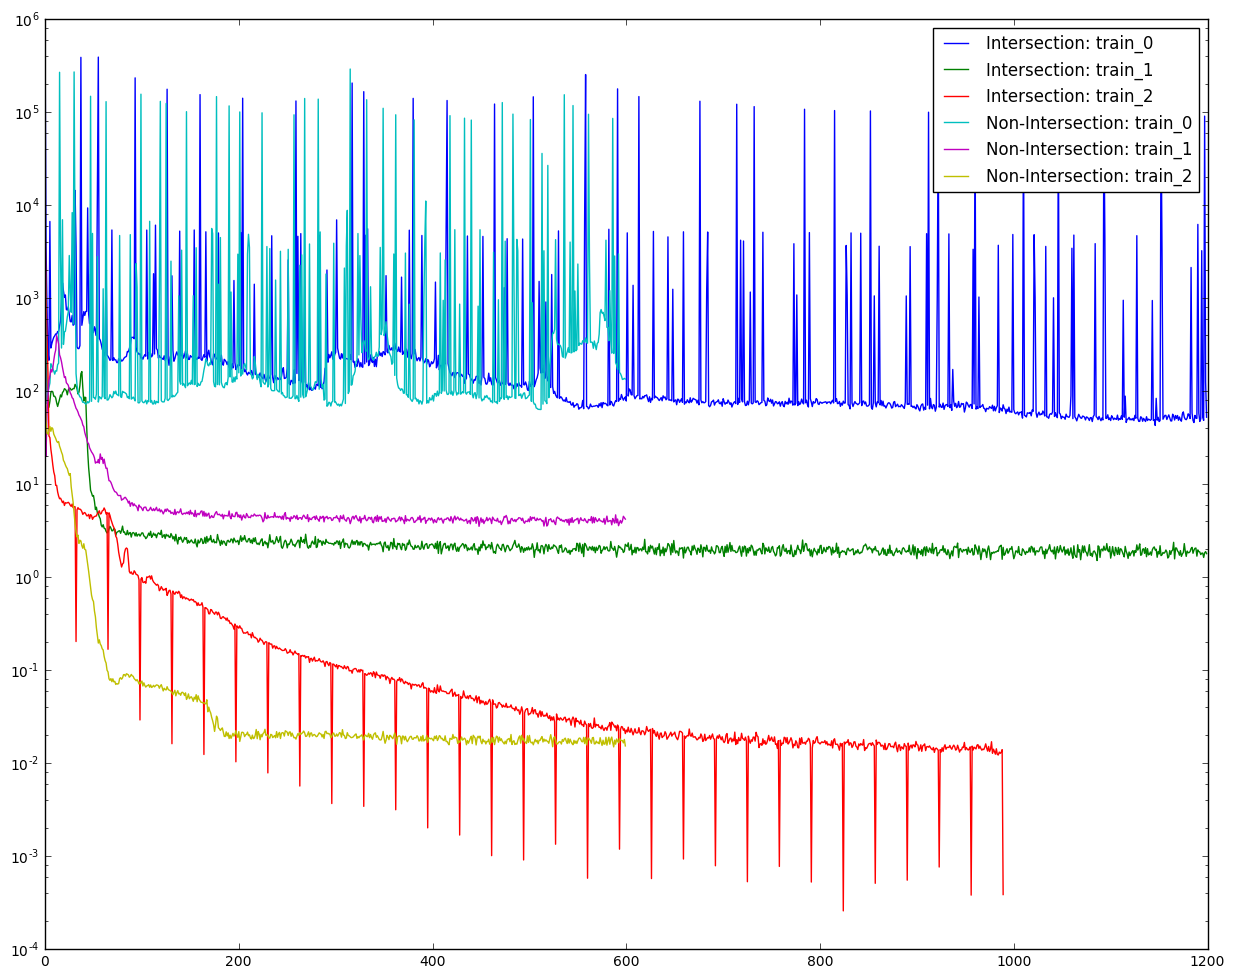

In [16]:
plt.figure(figsize=(15, 12))
for name in ['Intersection', 'Non-Intersection']:
    for k, (train_loss, val_loss) in enumerate(losses[name]):
        plt.semilogy(train_loss, label='{}: train_{}'.format(name, k))
    #     plt.semilogy(np.arange(len(val_loss)) * 20, val_loss, label='val_{}'.format(k))
    plt.legend();

In [17]:
lstm_optimizers = {'intersection': opt_intersection, 'non-intersection': opt_non_intersection}

In [ ]:
from collections import namedtuple
TestCase = namedtuple('TestCase', 'n_iter n_functions')

In [ ]:
tests = [
    TestCase(n_iter=20, n_functions=50), 
    TestCase(n_iter=60, n_functions=50),
    TestCase(n_iter=500, n_functions=50),
    TestCase(n_iter=500, n_functions=1)
]

tests_results = []

for n_iter, n_functions in tests:
    testing_options = {
        'n_iter'     : n_iter,
        'n_functions': n_functions,
        'sampler'    : multisampler,
        'normalize': True
    }
    histories = test_optimizers(lstm_optimizers, non_lstm_optimizers, **testing_options)
    tests_results.append(histories)

Testing lstm; intersection
Testing lstm; non-intersection
Testing sgd
Testing momentum
Testing lbfgs
Testing lstm; intersection
Testing lstm; non-intersection
Testing sgd
Testing momentum
Testing lbfgs
Testing lstm; intersection
Testing lstm; non-intersection
Testing sgd
Testing momentum
Testing lbfgs
Testing lstm; intersection


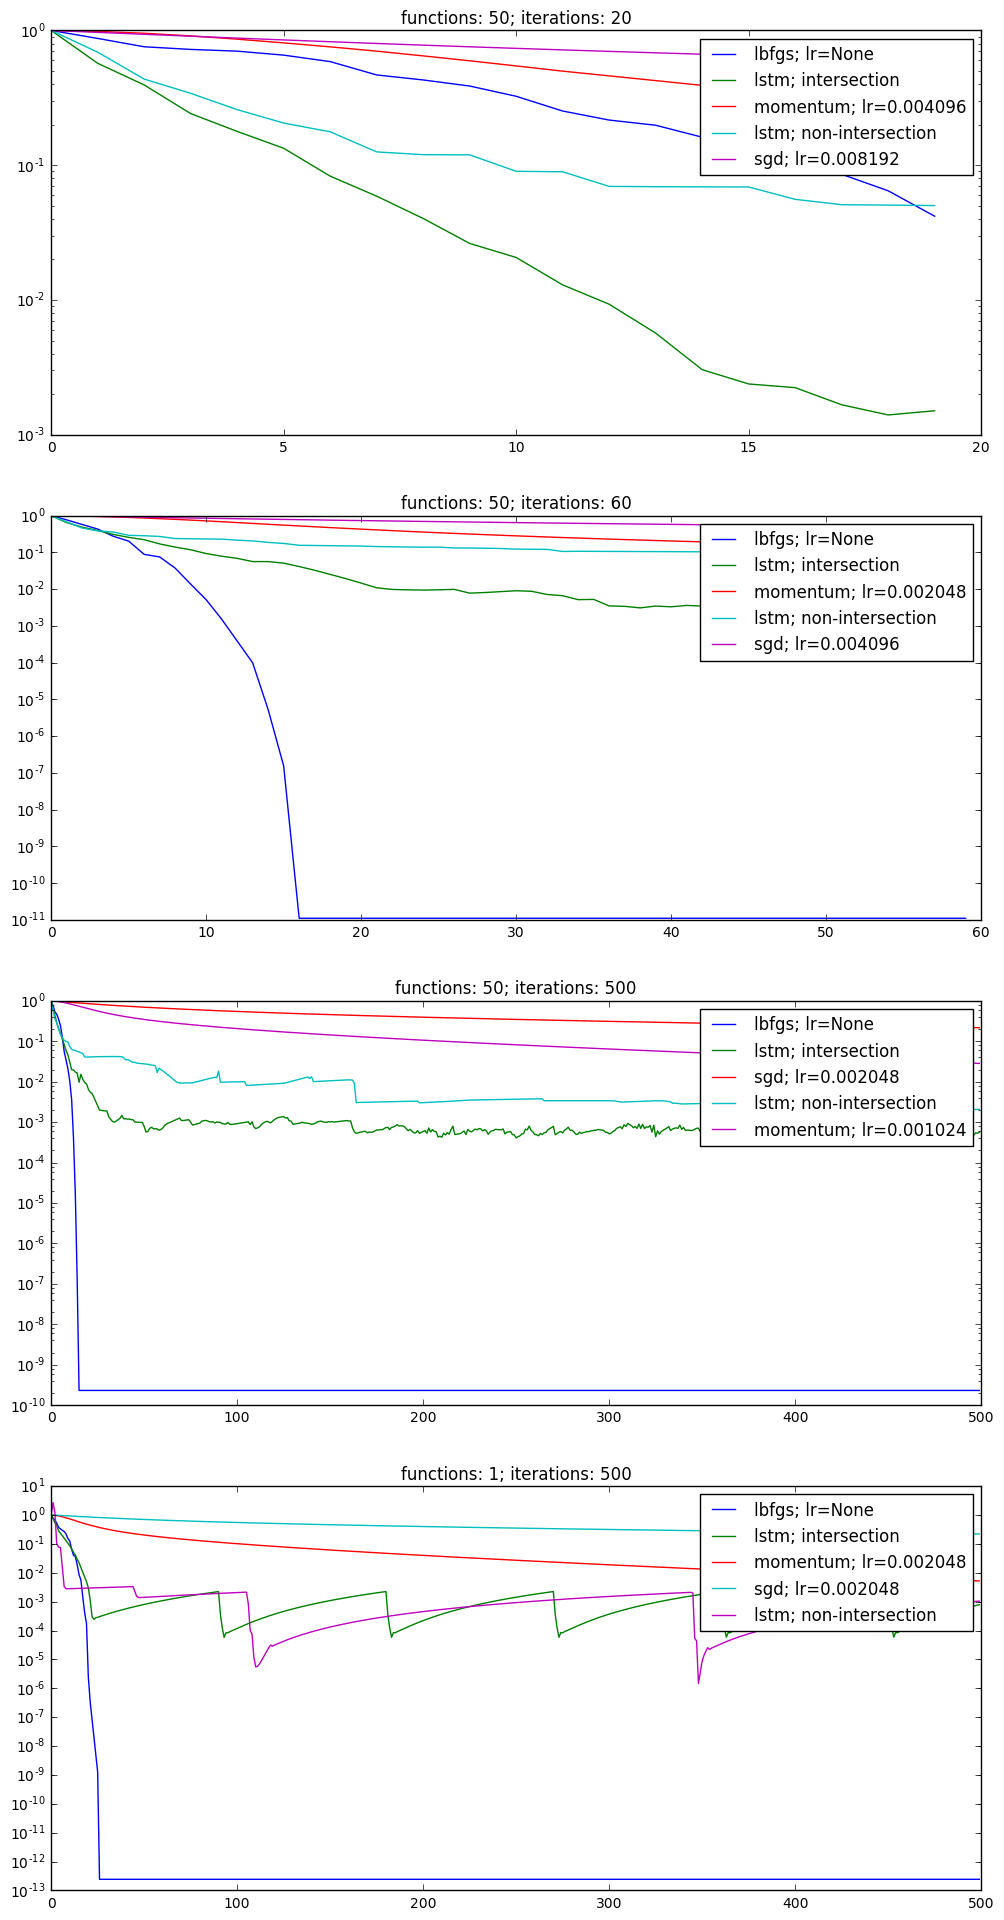

In [25]:
%matplotlib inline
fig, axes = plt.subplots(len(tests_results), figsize=(12, 6 * len(tests_results)))

if len(tests_results) == 1:
    axes = (axes,)

for ax, (n_iter, n_functions), h in zip(axes, tests, tests_results):
    for name, hist in h.items():
        ax.semilogy(hist, label=name)
    
    ax.set_title('functions: {}; iterations: {}'.format(n_functions, n_iter))
    ax.legend()
    
# fig.tight_layout()

(-2.035988509849953, 4.1452492122410325)


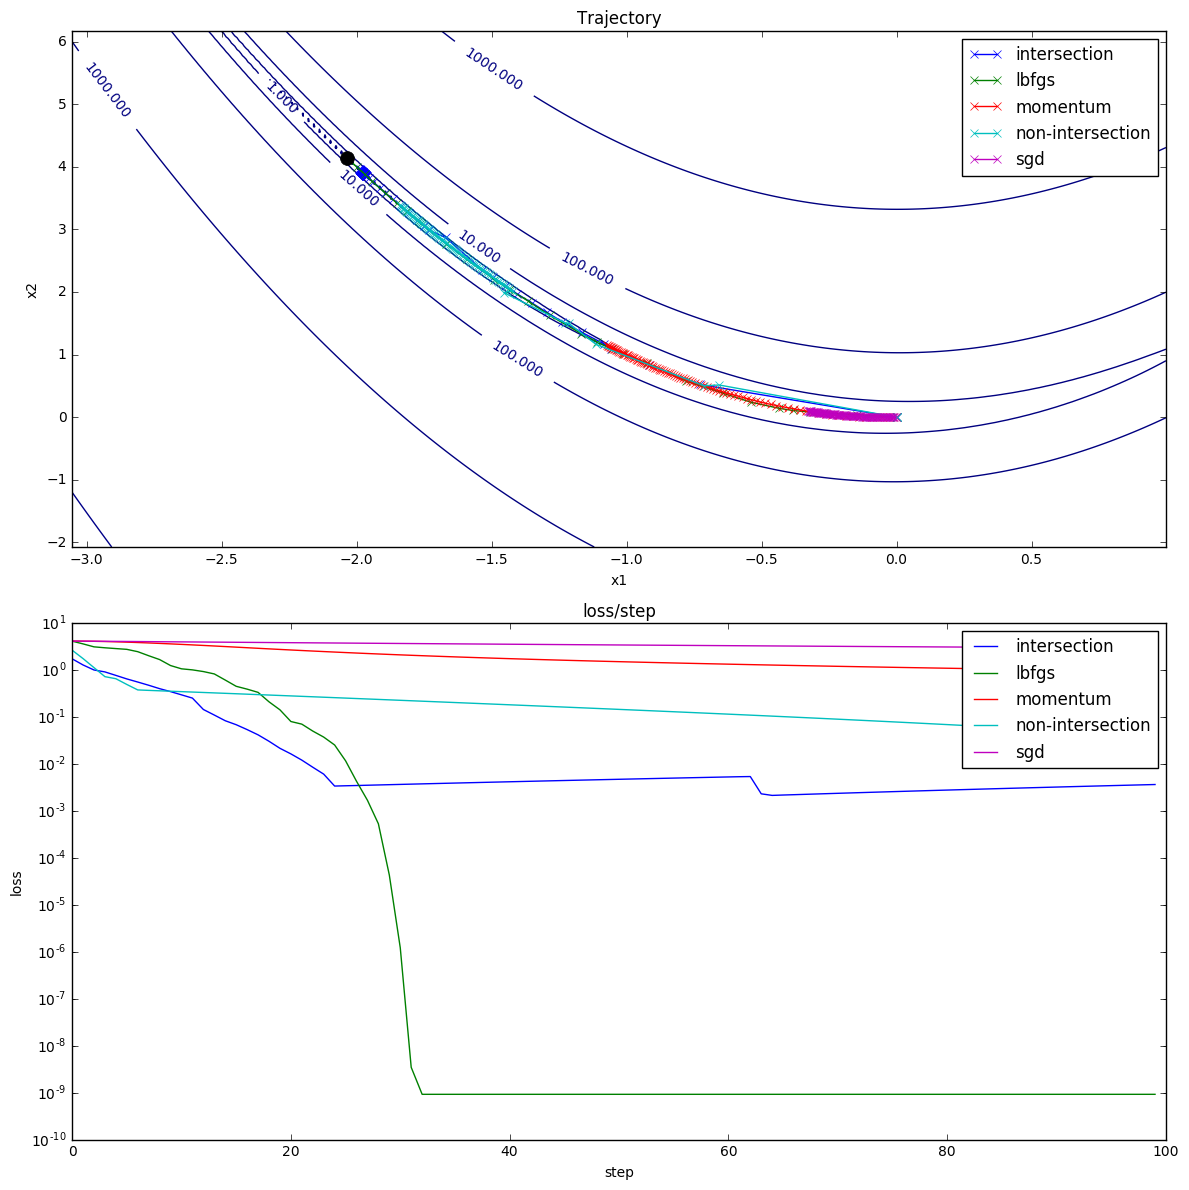

In [26]:
draw_trajectory(100, sample_point_and_params(ndim=2, sample_point=sample_point), lstm_optimizers, non_lstm_optimizers)

(-2.3637651096932952, 5.587385493803356)


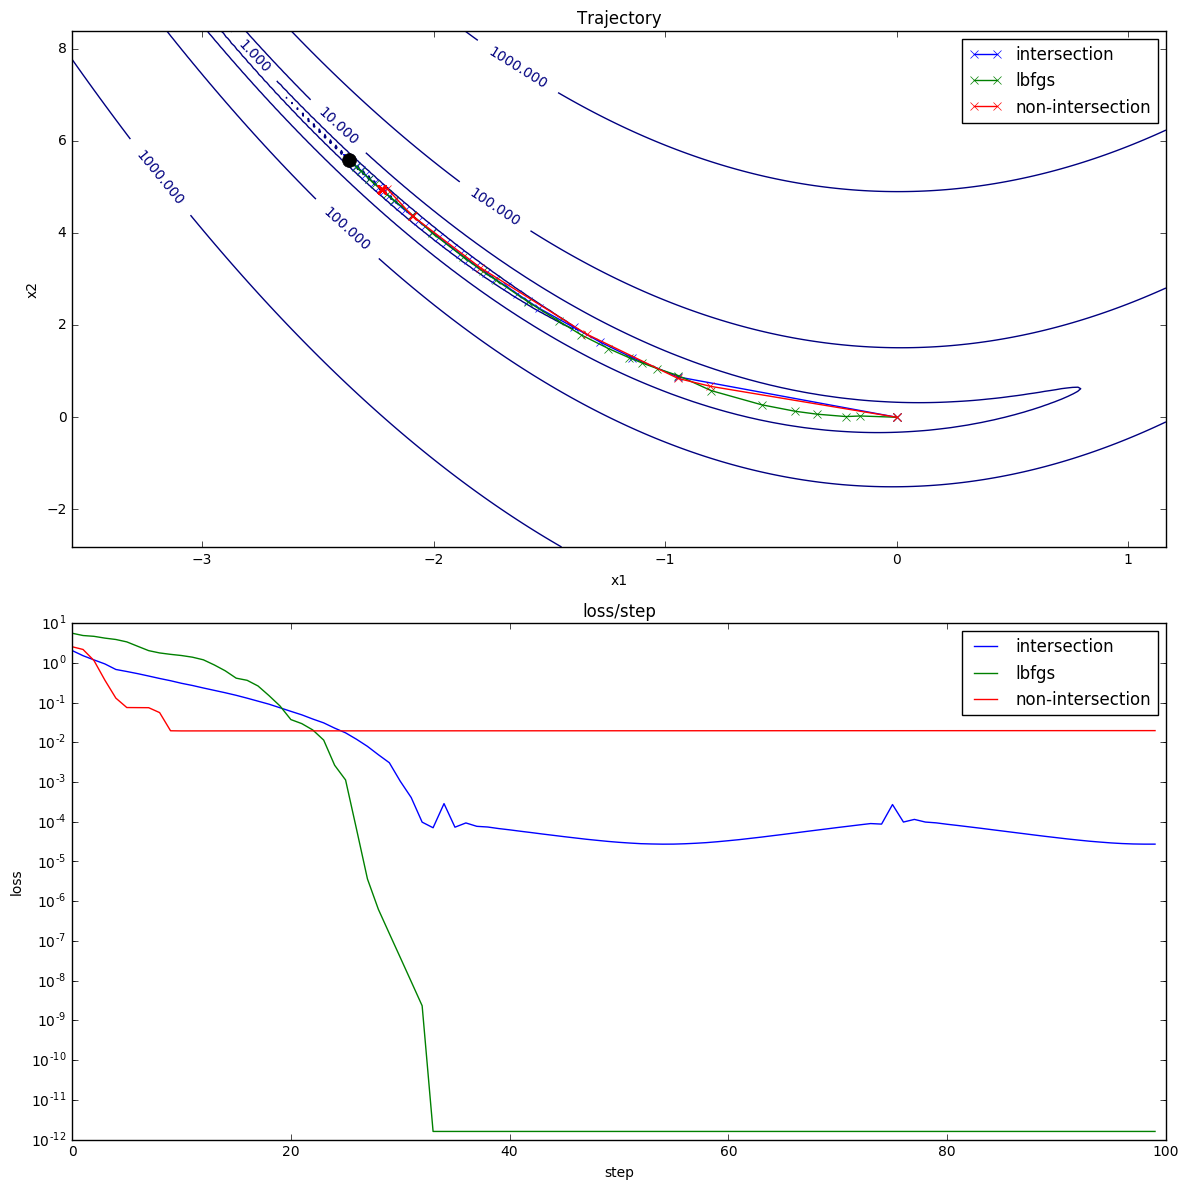

In [27]:
draw_trajectory(100, sample_point_and_params(ndim=2, sample_point=sample_point), lstm_optimizers, {k: v for k, v in non_lstm_optimizers.items() if k == 'lbfgs'})

(-1.338238508242486, 1.790882304943074)


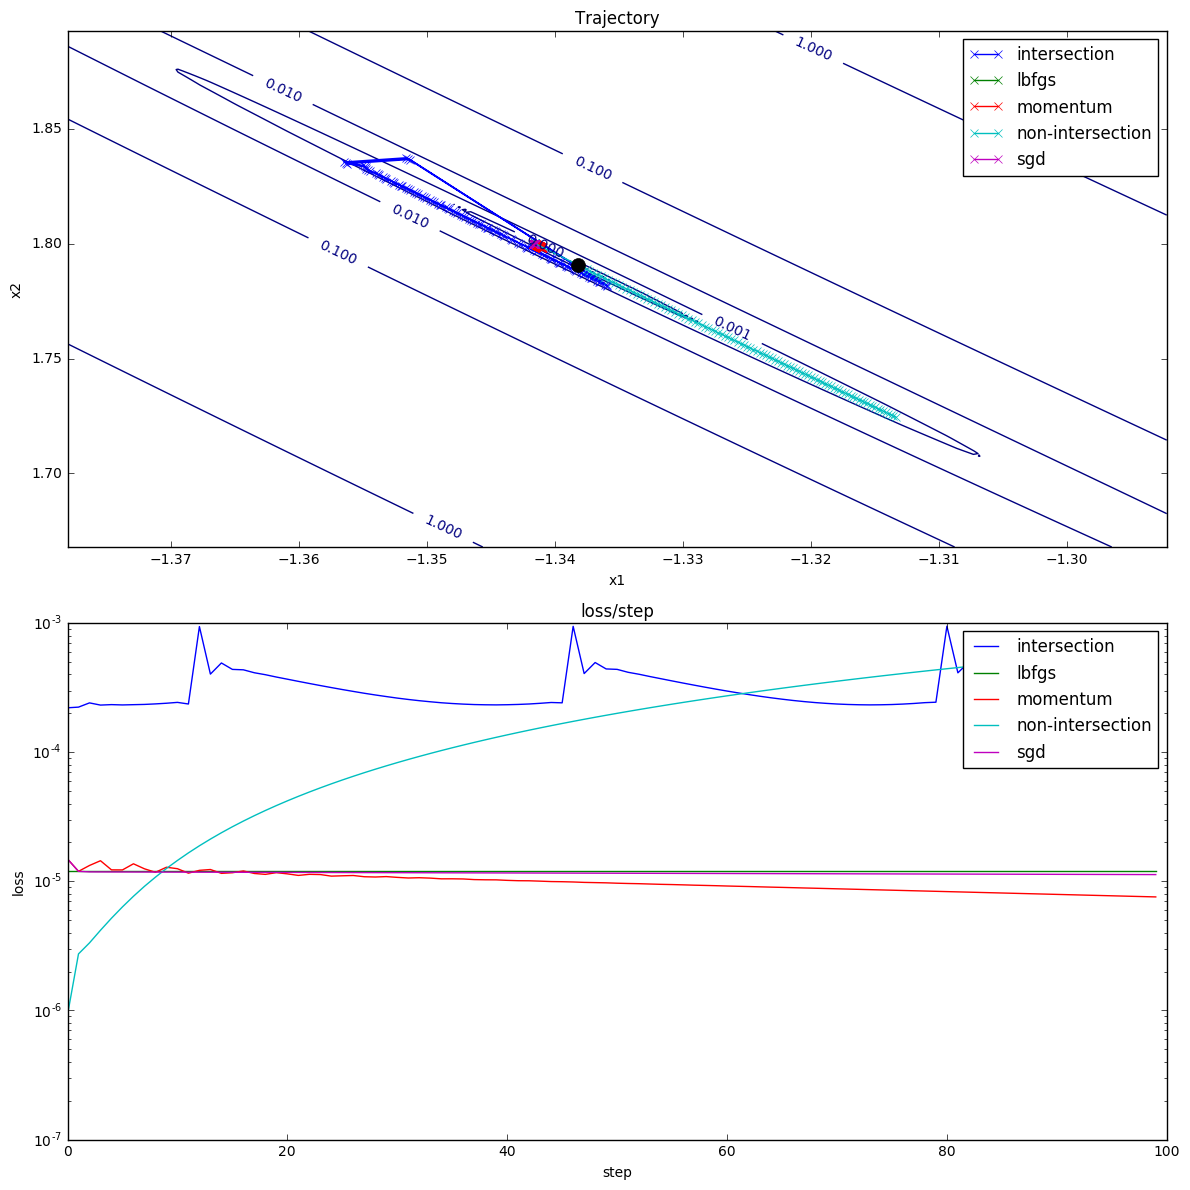

In [28]:
draw_trajectory(100, sample_point_and_params(ndim=2, sample_point=sample_point_second_phase), lstm_optimizers, non_lstm_optimizers)

(-1.5982403644236127, 2.5543722624729224)


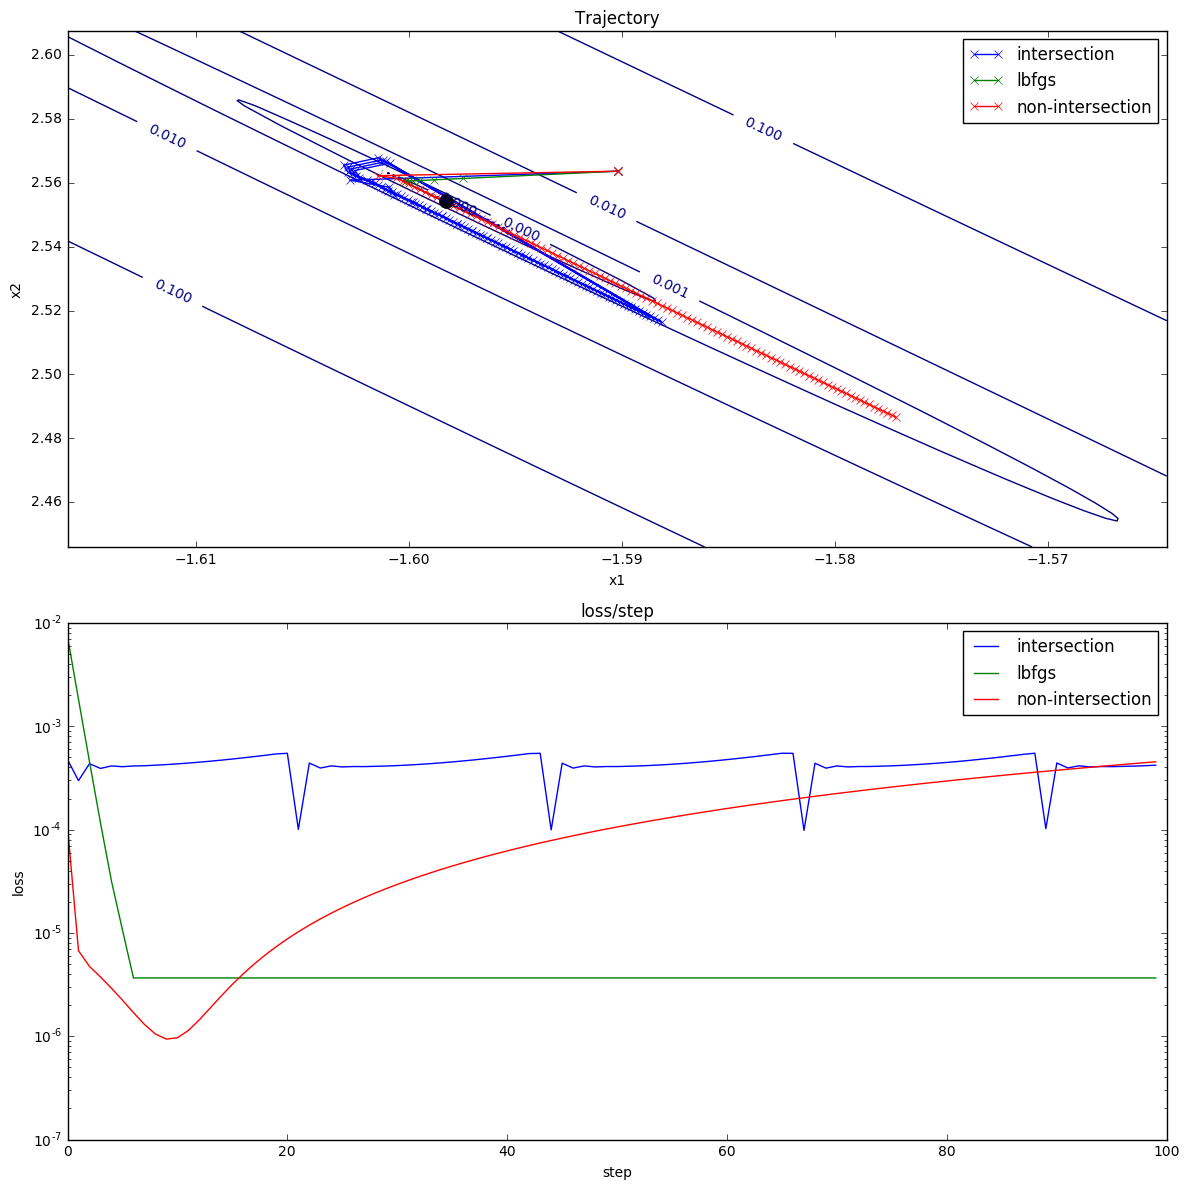

In [29]:
draw_trajectory(100, sample_point_and_params(ndim=2, sample_point=sample_point_second_phase), lstm_optimizers, {k: v for k, v in non_lstm_optimizers.items() if k == 'lbfgs'})